# Vanilla Deep Q-Learning 
---
In this notebook, you will implement a DQN agent with OpenAI Gym's [Cart Pole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) - environment.

This is a relatively simple version of the algorithm, it differs from classical Q-Learning in four main ways:
- we are using a neural network to estimate the state-action value
- the neural network estimates all state-action values for a given state
- we are using Replay Buffer to store the `s, a, r, s', done` tuples, and learning from the data sampled from the Replay Buffer, not from immediate experience.
- we are using the decaying exploration rate $\epsilon$. In the beginning of learning the agent is exploring a lot, and the exploration rate is reduced in time.

Your task is to complete the code in this notebook. The places were you should create your own implementation are described in this notebook and marked with `# ENTER YOUR CODE HERE` comments.

*Note: This code uses replay buffer implemented in the `reply_buffer.py` file. This implementation comes from [OpenAI baselines GitHub repository](https://github.com/openai/baselines/tree/master/baselines/deepq).*


In [1]:
# Import packages
import gym
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Device:', device)

Device: cuda:0


In [2]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --upgrade gym


In [4]:
env = gym.make('CartPole-v1')

### Task 1 - Implement the neural network
Implement the neural network (`QNetwork` class):
1) In `__init__()` Create a neural network
2) In `forward()` implement the forward pass with ReLU

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class QNetwork(nn.Module):
    """Fully connected (dense) neural network that estimates Q values."""

    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Args:
            state_size (int): Dimension of each state. It equals
                the number of features in the network.
            action_size (int): Dimension of each action. It equals 
                the number of the network outputs
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values.
        Args:
            state (torch.Tensor): The state of the environment
        Returns:
            torch.Tensor: The action values
        """

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Task 2 - Implement the Agent:
Implement the `Agent` class.
1) In `__init__()` create a neural network, optimizer and Replay Buffer
2) In `step()` add the experience to the memory buffer
3) In `learn()` calculate `Q_targets` and `loss`

In [6]:
import numpy as np
import random

from replay_buffer import ReplayBuffer

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size,
                 buffer_size = int(1e5),
                 batch_size = 64,
                 gamma = 0.99,
                 lr = 5e-4,
                 update_every = 4,
                 device = None):
        """Initialize an Agent object.
        Args:
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            buffer_size (int): replay buffer size. Default: int(1e5)
            batch_size (int): minibatch size. Default: 64
            gamma (float): discount factor. Default: 0.99
            lr (float): learning rate. Default: 5e-4
            update_every (int): how often to update the network. Default: 1        
            device (torch.device): device to use. Default: None    
        """
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every
        self.device = device

        # Q-Network
        fc1, fc2 = 64, 16 # Size of the layers
        # TODO: Create a network with 2 hidden layers (fc1 and fc2 nodes)
        self.qnetwork = QNetwork(state_size, action_size, fc1, fc2).to(device)
        
        # TODO: Create the optimizer (Adam with learning rate lr)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=lr)

        # TODO: Create a Replay Buffer. Use ReplayBuffer class from the 
        # reply_buffer.py file. Use buffer_size as the buffer size
        self.memory = ReplayBuffer(buffer_size)
        
        # Initialize time step (for updating every self.update_every steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        
        # TODO: Save experience in replay buffer. Use self.memory.add()
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every self.update_every time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample(self.batch_size)
                self.learn(experiences)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork.eval()
        with torch.no_grad():
            action_values = self.qnetwork(state)
        self.qnetwork.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        device = self.device  # for shortening the following lines
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions.reshape(-1, 1)).to(device)
        rewards = torch.FloatTensor(rewards.reshape(-1, 1)).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones.reshape(-1, 1)).to(device)        
        
        # Get max predicted Q values (for next states) from target model
        Q_next = self.qnetwork(next_states).detach().max(dim=1, keepdim=True)[0]
        # TODO: Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_next * (1 - dones))

        # Get expected Q values
        Q_curr = self.qnetwork(states).gather(1, actions)

        # TODO: Calculate loss. Use F.mse_loss
        loss = F.mse_loss(Q_curr, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def save(self, path = 'checkpoint.pth'):
        """Saves the network
        Args:
            path (str): path to save the network. Default is 'checkpoint.pth'
        """
        torch.save(self.qnetwork.state_dict(), path)
 
 
    def load(self, path = 'checkpoint.pth'):
        """Loads the network
        Args:
            path (str): path with the weights. Default is 'checkpoint.pth'
        """
        self.qnetwork.load_state_dict(torch.load(path))
        
agent = Agent(
    state_size=env.observation_space.shape[0], 
    action_size=env.action_space.n, device = device)        

### Task 3. Train the Agent
Complete the `train_agent()` function.
1) Select and perform an action
2) Use `agent.step()` to update the agent's knowledge
3) Decay the explorarion rate epsilon


In [7]:
def train_agent(
        n_episodes = 3000,    # Maximum number of episodes
        max_t = 1000,         # Maximum number of timesteps per episode
        eps_start = 1.0,      # Starting value of epsilon
        eps_end = 0.01,       # Minimum value of epsilon
        eps_decay = 0.995,    # Decay rate of epsilon
        expected_reward = 230 # Expected average reward to solve the environment

        ):
    """Deep Q-Learning.
    Args:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for 
            epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): decay factor (per episode) 
            for decreasing epsilon
        expected_reward (float): finish when the average score
            is greater than this value
    Returns:
        scores (list): list of scores from each episode
    """
    scores = []                        
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for episode in range(1, n_episodes+1):
        state, info = env.reset()
        score = 0
        for t in range(max_t):
            # TO DO: select an action
            action = agent.act(state, eps)
            next_state, reward, done, truncated, info = env.step(action)
            
            # TO DO: use agent.step() to update the agent
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       
        scores.append(score)
        
        # TO DO: Decay epsilon by multiplying it by eps_decay             
        eps = max(eps_end, eps_decay*eps) 
        
        mean_score = np.mean(scores_window)
        
        print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}     ', end="")
        
        if episode % 100 == 0:
            
            print(f'\rEpisode {episode}\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
        if mean_score >= expected_reward:
            print(f'\nDone in {episode:d} episodes!\tAverage Score: {mean_score:.2f}')
            agent.save('checkpoint.pth')
            break
    return scores

### Train the agent

Episode 100	Average Score: 20.35     
Episode 200	Average Score: 14.77     
Episode 300	Average Score: 39.97     
Episode 400	Average Score: 136.23     
Episode 500	Average Score: 199.65     
Episode 600	Average Score: 200.37     
Episode 700	Average Score: 212.35     
Episode 800	Average Score: 222.82     
Episode 900	Average Score: 230.02     

Done in 900 episodes!	Average Score: 230.02


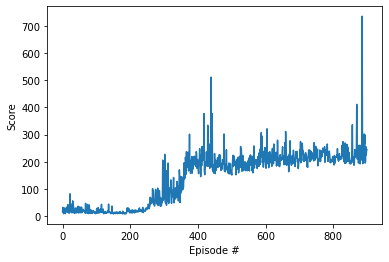

In [8]:
scores = train_agent()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Visualize the agent's performance

In [11]:
from IPython.display import HTML
from base64 import b64encode
import imageio

def create_video(agent, video_path):
    env = gym.make('CartPole-v1', render_mode = 'rgb_array')

    state, _ = env.reset()
    img_list = [env.render()]

    for t in range(1000):
        action = agent.act(state, 0)
        state, reward, done, _, _ = env.step(action)
        img_list.append(env.render())
        state, reward, done, _, _ = env.step(action)
        if done:
            break 
    env.close()

    # Create a video file using imageio
    imageio.mimsave(video_path, img_list, fps=30)

    print (f'Visualization done. Episode ended after {t} steps.')
    
    return img_list

video_path = 'output.mp4'
create_video(agent, video_path)

mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>
""" % data_url)


c:\Users\Przemek\anaconda3\envs\gym\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Visualization done. Episode ended after 104 steps.
